In [ ]:
import pandas as pd
import numpy as np
import geopandas as gpd
from geopandas import GeoDataFrame
import geoplot
from shapely.geometry import Point
import matplotlib.pyplot as plt
from sklearn import cluster
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import scipy.cluster.hierarchy as sch

## Initial Plot of non-binned data

In [4]:
pop_df = pd.read_csv('../processed_data/density/geocoded_population.csv')
traf_df = pd.read_csv('../processed_data/density/geocoded_traffic.csv')
ped_df = pd.read_csv('../processed_data/density/geocoded_pedestrian.csv')
fac_df = pd.read_csv('../processed_data/buildings/facilities.csv')
hot_df = pd.read_csv('../processed_data/buildings/hotels.csv')
lib_df = pd.read_csv('../processed_data/buildings/libraries.csv')
park_df = pd.read_csv('../processed_data/buildings/parks.csv')


crs = {'init': 'epsg:2263'}

In [ ]:
df_list = [pop_df, traf_df, ped_df, fac_df, hot_df, lib_df, park_df]
new_df_list = llz_set(df_list)

KeyError: 'NTA_long'

In [ ]:
boroughs = gpd.read_file(geoplot.datasets.get_path('nyc_boroughs'))
boroughs.plot(ax=ax,alpha=0.4,color="grey")

fig,ax=plt.subplots(figsize=(20,20))
new_df_list[0].plot(ax = ax, markersize = 15, color = 'blue', marker = 'o', label = 'population')
new_df_list[1].plot(ax = ax, markersize = 5, color = 'red', marker = 'o', label = 'traffic')
new_df_list[2].plot(ax = ax, markersize = 5, color = 'green', marker = 'o', label = 'ped_traffic')
new_df_list[3].plot(ax = ax, markersize = 5, color = 'orange', marker = 'o', label = 'facilities')
new_df_list[4].plot(ax = ax, markersize = 5, color = 'purple', marker = 'o', label = 'hotels')
new_df_list[5].plot(ax = ax, markersize = 5, color = 'yellow', marker = 'o', label = 'libraries')
new_df_list[6].plot(ax = ax, markersize = 5, color = 'pink', marker = 'o', label = 'parks')

plt.legend()
plt.savefig('../Mid-Term-Project/figures/pre_bin_map.png')

## Elbow Plot

In [4]:
master_df = pd.read_csv('../processed_data/master.csv')

In [5]:
X = master_df.iloc[:, 2:]
lat_lng = master_df.iloc[:, 0:2]

In [6]:
#Scaling the data
scaler = StandardScaler()
#fit scaler to data
scaler.fit(X.values)

#transform and save into new dataframe
X_std = pd.DataFrame(scaler.transform(X.values), 
                                columns = X.columns)
    
X_std.head()

,Population,traffic,ped_traffic,count_x,acres,count_y,PARKING LOTS AND GARAGES,NON-PUBLIC K-12 SCHOOLS,HOSPITALS AND CLINICS,PUBLIC K-12 SCHOOLS,"STREETSCAPES, PLAZAS, AND MALLS",BUS DEPOTS AND TERMINALS,MUSEUMS,COLLEGES OR UNIVERSITIES
0,-0.837351,-0.637258,-0.379571,-0.152898,0.834789,-0.197862,0.308110,-0.412739,-1.065555,-1.009000,-0.633610,0.131304,0.170919,-0.453408
1,-0.636818,-0.119831,-0.379571,-0.152898,1.579880,-0.214343,-0.530724,-0.565171,-0.716633,-1.009000,-0.633610,-0.370740,-0.413805,-0.453408
2,-0.952083,0.069818,-0.379571,-1.572667,0.461823,-0.214343,-0.635578,-0.717602,-1.065555,-0.797435,-0.972114,0.131304,0.170919,-0.453408
3,-1.886269,-0.795459,-0.379571,-1.572667,-0.392163,-0.230824,-0.688006,-0.870034,-1.065555,-1.643693,-0.972114,-0.370740,-0.413805,-0.453408
4,-0.054161,0.075751,-0.379571,-0.152898,0.765566,-0.230824,-0.583151,-0.107875,-1.065555,-0.374306,-0.633610,-0.370740,-0.413805,-0.453408


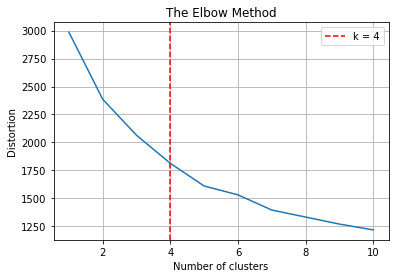

<Figure size 432x288 with 0 Axes>

In [97]:
max_k = 10
## iterations
distortions = [] 
for i in range(1, max_k+1):
    if len(X_std) >= i:
        model = cluster.KMeans(n_clusters=i, init='k-means++', max_iter=100, n_init=10)
        model.fit(X_std)
        distortions.append(model.inertia_)

k = [i*100 for i in np.diff(distortions,2)].index(min([i*100 for i 
     in np.diff(distortions,2)]))

fig, ax = plt.subplots()
ax.plot(range(1, len(distortions)+1), distortions)
ax.axvline(k, ls='--', color="red", label="k = "+str(k))
ax.set(title='The Elbow Method', xlabel='Number of clusters', 
       ylabel="Distortion")
ax.legend()
ax.grid(True)
plt.show()
plt.savefig('../figures/elbow-method.png')

## PCA

In [6]:
pca = PCA()
principalComponents = pca.fit_transform(X_std)
PCA_components = pd.DataFrame(principalComponents)

NameError: name 'X_std' is not defined

In [19]:
km = KMeans(n_clusters=5, n_init=1000)
y_km = km.fit_predict(principalComponents)

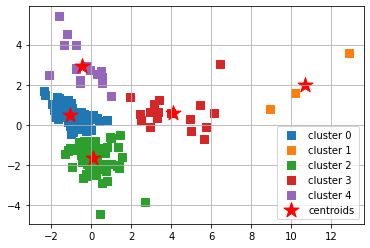

In [20]:
plot_clusters(principalComponents, y_km, plt_cluster_centers= True)

In [7]:
def plot_dendrogram(X,method ='ward'):
    dendrogram = sch.dendrogram(sch.linkage(X, method=method))
    plt.title("Dendrogram")
    plt.ylabel("Euclidean distances")
    plt.xlabel('Points')
    plt.show()

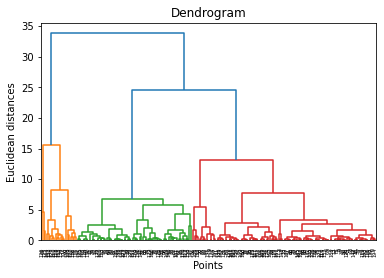

In [28]:
plot_dendrogram(PCA_components)